**Problem 2 d) DermaMNIST  -   three quantization
techniques**



In [1]:
# Install medmnist
!pip install medmnist

# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from medmnist import DermaMNIST

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9910747fb91f0ed4b7a975df79fae76c47932539cedaec0643e56cae7cd66ce4
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
# Loading the dataset
train_dataset = DermaMNIST(split="train", download=True)
val_dataset = DermaMNIST(split="val", download=True)
test_dataset = DermaMNIST(split="test", download=True)


100%|██████████| 19.7M/19.7M [00:01<00:00, 10.3MB/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [3]:
# Original labels - Before one-hot encoding
print("Original label shape:", train_dataset.labels.shape)
print("First 5 labels:", train_dataset.labels[:5].flatten())

# labels shape - After one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(train_dataset.labels, num_classes=7)
print("One-hot encoded label shape:", labels_encoded.shape)
print("First 5 one-hot encoded labels:\n", labels_encoded[:5])



Original label shape: (7007, 1)
First 5 labels: [0 5 5 5 4]
One-hot encoded label shape: (7007, 7)
First 5 one-hot encoded labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [4]:
# Normalization
def prepare_data(dataset):
    images = dataset.imgs / 255.0
    labels = tf.keras.utils.to_categorical(dataset.labels, num_classes=7)
    return images, labels

x_train, y_train = prepare_data(train_dataset)
x_val, y_val = prepare_data(val_dataset)
x_test, y_test = prepare_data(test_dataset)


In [5]:
from sklearn.utils import class_weight

# Converting the one-hot encoded values to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.390350877192983, 1: 2.788300835654596, 2: 1.3016905071521456, 3: 12.5125, 4: 1.2849807445442876, 5: 0.21329639889196675, 6: 10.11111111111111}


##### Post-training dynamic range quantization

In [6]:
# Model with augmentation
def build_model():
    model = models.Sequential([
        # 1st Conv Layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 2nd Conv Layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 3rd Conv Layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.GlobalAveragePooling2D(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

    # 4th Conv Layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),

        layers.Flatten(),

    # Fully Connected Layers (3 Layers)
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# using various image aug techniques
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(x_train)

#  model with augmentation  - 150 epochs
aug_model = build_model()
aug_history = aug_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=150,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 21s - 191ms/step - accuracy: 0.6425 - loss: 1.0818 - val_accuracy: 0.0518 - val_loss: 2.0773
Epoch 2/150
110/110 - 16s - 141ms/step - accuracy: 0.6730 - loss: 0.9161 - val_accuracy: 0.0788 - val_loss: 2.4127
Epoch 3/150
110/110 - 17s - 154ms/step - accuracy: 0.6867 - loss: 0.8756 - val_accuracy: 0.1137 - val_loss: 2.2647
Epoch 4/150
110/110 - 16s - 142ms/step - accuracy: 0.6956 - loss: 0.8612 - val_accuracy: 0.5294 - val_loss: 1.2759
Epoch 5/150
110/110 - 16s - 147ms/step - accuracy: 0.6987 - loss: 0.8348 - val_accuracy: 0.6740 - val_loss: 0.8888
Epoch 6/150
110/110 - 20s - 182ms/step - accuracy: 0.7014 - loss: 0.8225 - val_accuracy: 0.6810 - val_loss: 0.8673
Epoch 7/150
110/110 - 16s - 147ms/step - accuracy: 0.7066 - loss: 0.8031 - val_accuracy: 0.6770 - val_loss: 0.8839
Epoch 8/150
110/110 - 21s - 188ms/step - accuracy: 0.7047 - loss: 0.7897 - val_accuracy: 0.7208 - val_loss: 0.7583
Epoch 9/150
110/110 - 20s - 181ms/step - accuracy: 0.7157 - loss: 0.7771 - val_accuracy: 0.7

In [7]:
# dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_dynamic = converter.convert()

# Save the quantized model to file
with open('aug_model_dynamic.tflite', 'wb') as f:
    f.write(tflite_model_dynamic)

print("Dynamic range quantization complete!")


Saved artifact at '/tmp/tmpov_x765y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138927088873920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089026320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927088868992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089031776:

In [8]:
import os

converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
tflite_model_fp32 = converter.convert()
with open('aug_model_fp32.tflite', 'wb') as f:
    f.write(tflite_model_fp32)

original_size = os.path.getsize("aug_model_fp32.tflite") / 1024
dynamic_size = os.path.getsize("aug_model_dynamic.tflite") / 1024

print(f"Original (FP32) model size: {original_size:.2f} KB")
print(f"Dynamic Quantized model size: {dynamic_size:.2f} KB")


Saved artifact at '/tmp/tmp791razyy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138927088873920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089026320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927088868992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089031776:

In [9]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="aug_model_dynamic.tflite")
interpreter.allocate_tensors()

# Get input and output tensors info
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Evaluate on test data
correct = 0
total = x_test.shape[0]

for i in range(total):
    input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    if np.argmax(output) == np.argmax(y_test[i]):
        correct += 1

quantized_acc = correct / total
print(f"Dynamic Quantized Model Test Accuracy: {quantized_acc:.4f}")


Dynamic Quantized Model Test Accuracy: 0.7342


##### Full Integer Quantization

In [10]:
# dataset generator
def representative_data_gen():
    for i in range(100):
        image = x_train[i].astype(np.float32)
        image = np.expand_dims(image, axis=0)
        yield [image]


In [11]:
# Full Integer Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_integer = converter.convert()

# Save to file
with open('aug_model_integer.tflite', 'wb') as f:
    f.write(tflite_model_integer)

Saved artifact at '/tmp/tmpw51r3tbq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138927088873920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089026320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927088868992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089031776:

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [12]:
import os

integer_size = os.path.getsize("aug_model_integer.tflite") / 1024  # in KB

print(f"Full Integer Quantized model size: {integer_size:.2f} KB")


Full Integer Quantized model size: 508.87 KB


In [13]:
# Load the integer quantized TFLite model
interpreter = tf.lite.Interpreter(model_path="aug_model_integer.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Evaluate accuracy on test data
correct = 0
total = x_test.shape[0]

for i in range(total):
    input_data = x_test[i].astype(np.float32)
    input_data = np.expand_dims(input_data, axis=0)

    # Convert input to int8 (quantize)
    scale, zero_point = input_details[0]['quantization']
    input_data = input_data / scale + zero_point
    input_data = np.clip(input_data, -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])

    if np.argmax(output) == np.argmax(y_test[i]):
        correct += 1

int_quant_acc = correct / total
print(f"The Full Integer Quantized Model Test Accuracy: {int_quant_acc:.4f}")


The Full Integer Quantized Model Test Accuracy: 0.7411


In [16]:
# Evaluate the original (FP32) model on the test set
original_test_acc = aug_model.evaluate(x_test, y_test, verbose=0)[1]


In [17]:
# Save the FP32 model (if you haven't already)
aug_model.save('aug_model_fp32.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(aug_model)
tflite_model_fp32 = converter.convert()

# Save the FP32 TFLite model to disk
with open('aug_model_fp32.tflite', 'wb') as f:
    f.write(tflite_model_fp32)

original_size = os.path.getsize("aug_model_fp32.tflite") / 1024  # in KB


Saved artifact at '/tmp/tmp78lxf363'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138927088873920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089026320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089028432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927088868992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089027728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089030720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089032128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138927089031776:

In [18]:
# Print results for model sizes and accuracies
print(f"Original Model (FP32) Test Accuracy: {original_test_acc:.4f}")
print(f"Original Model (FP32) Size: {original_size:.2f} KB")

print(f"Dynamic Range Quantized Model Test Accuracy: {quantized_acc:.4f}")
print(f"Dynamic Range Quantized Model Size: {dynamic_size:.2f} KB")

print(f"Full Integer Quantized Model Test Accuracy: {int_quant_acc:.4f}")
print(f"Full Integer Quantized Model Size: {integer_size:.2f} KB")


Original Model (FP32) Test Accuracy: 0.7352
Original Model (FP32) Size: 1917.29 KB
Dynamic Range Quantized Model Test Accuracy: 0.7342
Dynamic Range Quantized Model Size: 504.85 KB
Full Integer Quantized Model Test Accuracy: 0.7411
Full Integer Quantized Model Size: 508.87 KB


**Comparison summary:**

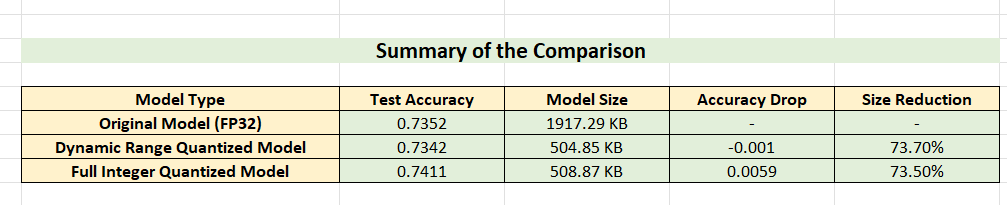

**Interpretations:**

- **Dynamic Range Quantization:** Here the smallest Model: 504.85 KB, slight accuracy drop. This is Best for memory-constrained devices (e.g., mobile, embedded) with minimal acceptable accuracy loss.
- **Full Integer Quantization:** Small Model: 508.87 KB, slight accuracy improvement. This is ideal for resource-constrained devices where both accuracy and model size matter.
- **Original FP32 Model:** Highest Accuracy: No accuracy loss, largest model size (1917.29 KB). This is the best when accuracy is the highest priority, and memory is not a constraint (e.g., cloud, high-performance servers).
- Therefpre we can say that

   i) Dynamic Range Quantization: Optimal for size-efficient deployment with minimal accuracy loss.
  
   ii) Full Integer Quantization: Best for a balance of small size and improved or maintained accuracy.

   iii) FP32 Model: Choose when top accuracy is crucial, and memory is not an issue.

In [64]:
aug_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,467,863 (5.60 MB)

 Trainable params: 488,967 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 977,936 (3.73 MB)

**Hyperparameters used**
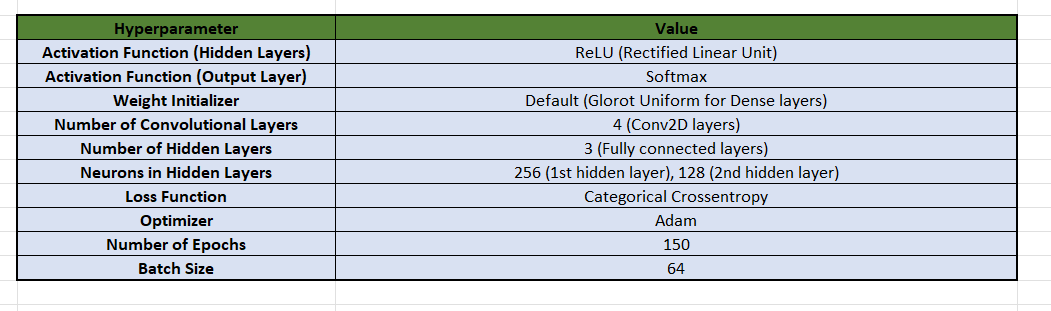
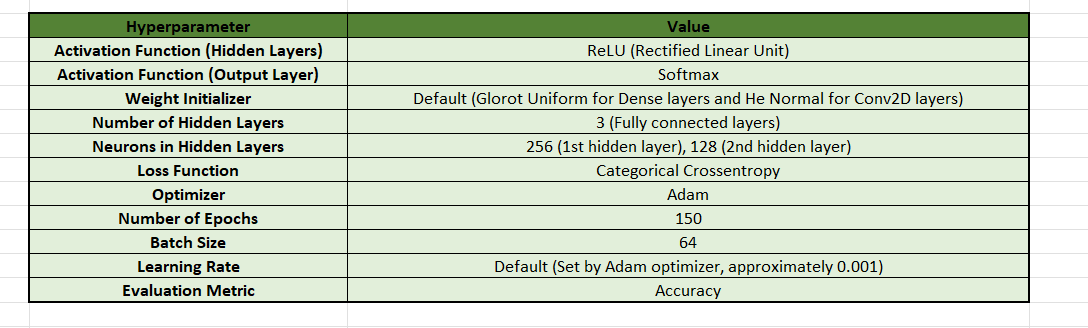